In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.signal as sigs
import numpy as np
import cmdstanpy ## import stan interface for Python
import os
import seaborn as sns
import pandas as pd
from importlib import reload 
import sys
sys.path.append("..")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from statannotations.Annotator import Annotator
from itertools import product

tex_fonts = {
    # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.grid": True,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '-',
    'grid.linewidth': 0.3,
    "lines.markersize":5,
    "lines.markeredgewidth":1,
    'axes.axisbelow':True,
    'pdf.fonttype':42,
    'axes.linewidth':0.5,
        'xtick.major.width':0.5,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3,

    'ytick.major.pad':0.2,
        "xtick.major.size":3,
    "ytick.major.size":3,
}

plt.rcParams.update(tex_fonts)

if os.name == "nt": ## adds compiler to path in Windows
    cmdstanpy.utils.cxx_toolchain_path() 
    
%config InlineBackend.close_figures=False # keep figures open in pyplot
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':"tight", 'pad_inches':2}

np.random.seed(2101)


ratio= 2/(1+np.sqrt(5))

width = 520.344

kwags = {"wspace":0.2}

my_pal = {"4cm": "g", 
          "4em": "m", 
          "donor":"#a4e0ef", 
          "host":"#ff7f0e",
         "WT":"#02feff",
         "Young CHIM":"#7d81fc",
         "Old CHIM":"#f50aff"}

my_marks = {"donor": "o", 
           "host": "X",
         "WT":"o",
         "Young CHIM":"P",
         "Old CHIM":"^"}

scatterkwags = {"palette": my_pal,
                  "markers":my_marks,
                  'edgecolor':"k",
}


def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #golden_ratio = (5**.5 - 1) / 2
    golden_ratio = 1

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

#loading dataframes for parameters and data
df_para = pd.read_csv('/home/elise/Code/BRDU/parameters_est.csv')
df = pd.read_csv('/home/elise/Code/BRDU/Elisehasbeenusing_dataUCL.csv',index_col='index')
df['age_cat']=np.where(df.age < 114, 'wt', pd.np.where((df.age >= 114) & (df.age < 180), 'Young', 'Old'))

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

def myMAP(data):
    
#     counts, x = np.histogram(data,bins=(np.int(np.rint(np.sqrt(len(data))))))
#     x_ind = np.unravel_index(np.argmax(counts), counts.shape)
# #     arrayed = data.to_numpy()

# #     i_peaks, _ = sigs.find_peaks(arrayed)

# #     i_peaks
# #     arrayed[i_peaks]

# #     # Find the index from the maximum peak
# #     i_max_peak = i_peaks[np.argmax(_['widths'])]

# #     # Find the x value from that index
# #     x_max = arrayed[i_max_peak]


# #     # Find the x value from that index
# #     x_max = arrayed[i_max_peak]
#     return x[x_ind]

    arrayed = data.to_numpy()
    nparam_density = sts.kde.gaussian_kde(arrayed)
    x = np.linspace(np.min(arrayed), np.max(arrayed), 2000)
    nparam_density = nparam_density(x)

    return x[np.argsort(nparam_density)[-1]]

In [2]:
#*************************************************************************************************************
#generate the dataframes curves


parnames = ["alpha_A","alpha_B","delta_A","delta_B","beta","Source","mu","eff"] 
pretty_parnames = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","Source","$\\mu$","$\\epsilon$"] #


m=0
pardf = pd.DataFrame()

ADHc = ['host','donor']
populationc = ['cm','em']

for adh_i, pop_i in product(ADHc,populationc):

    location = '/opt/mesh/tiree/elise/samples_1/oldmice_r16/stan-cache-4'+pop_i+adh_i+'_1/'
    sys.path.insert(1, location)
    import paras
    reload(paras)

    fl = []
    fb = [] 
    for f_name in os.listdir(location):
        if f_name.endswith('.csv')&f_name.startswith('branched'):
            print(f_name)
            fb.append(location+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('linear'):
            print(f_name)
            fl.append(location+f_name)

    sam_fb = cmdstanpy.from_csv(fb)
    sam_fl = cmdstanpy.from_csv(fl)
    

    parests_flvl = [sam_fl.stan_variable(pn) for pn in parnames]
    parests_fbvl = [sam_fb.stan_variable(pn) for pn in parnames]

    k_hat_fl =  sam_fl.stan_variable("k_hat")
    k_hat_fb =  sam_fb.stan_variable("k_hat")
    
    clonalL = np.zeros((len(k_hat_fl),100,8))
    clonalB = np.zeros((len(k_hat_fl),100,8))
    
    
    print(pop_i)
    print(adh_i)
    pardf_lvl=pd.DataFrame(np.transpose(parests_flvl), columns = parnames)
    pardf_lvl['age'] = 'Old Chim'
    pardf_lvl['type']='linear'
    pardf_lvl['population']=paras.populationc
    pardf_lvl['doh']=paras.ADHc
    pardf_lvl['popdoh']=paras.populationc+paras.ADHc
    pardf_lvl['ones']=1
    pardf_lvl['sourcedata']=paras.SourceL
    pardf_lvl['fastcount']=np.median(np.sum(k_hat_fl[:,:,0:paras.switch],axis=2), axis=1)
    pardf_lvl['slowcount']=np.median(np.sum(k_hat_fl[:,:,paras.switch:],axis=2), axis=1)
    pardf_lvl['totalcount']=np.median(np.sum(k_hat_fl[:,:,:],axis=2), axis=1)
    clonalL[:,:,m] = sam_fl.stan_variable('clonal') 
    
    
    pardf_bvl=pd.DataFrame(np.transpose(parests_fbvl), columns = parnames)
    pardf_bvl['age'] = 'Old Chim'
    pardf_bvl['type']='branched'
    pardf_bvl['population']=paras.populationc
    pardf_bvl['doh']=paras.ADHc
    pardf_bvl['popdoh']=paras.populationc+paras.ADHc
    pardf_bvl['ones']=1
    pardf_bvl['sourcedata']=paras.SourceB
    pardf_bvl['fastcount']=np.median(np.sum(k_hat_fb[:,:,0:paras.switch],axis=2), axis=1)
    pardf_bvl['slowcount']=np.median(np.sum(k_hat_fb[:,:,paras.switch:],axis=2), axis=1)
    pardf_bvl['totalcount']=np.median(np.sum(k_hat_fb[:,:,:],axis=2), axis=1)
    clonalB[:,:,m] = sam_fb.stan_variable('clonal') 

    m=m+1
    pardf = pd.concat([pardf,pardf_lvl, pardf_bvl])

for adh_i, pop_i in product(ADHc,populationc):

    location = '/opt/mesh/tiree/elise/samples_1/youngmice_r10/stan-cache-4'+pop_i+adh_i+'_1/'
    sys.path.insert(1, location)
    import paras
    reload(paras)

    fl = []
    fb = [] 
    for f_name in os.listdir(location):
        if f_name.endswith('.csv')&f_name.startswith('branched'):
            print(f_name)
            fb.append(location+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('linear'):
            print(f_name)
            fl.append(location+f_name)

    sam_fb = cmdstanpy.from_csv(fb)
    sam_fl = cmdstanpy.from_csv(fl)

    k_hat_fl =  sam_fl.stan_variable("k_hat")
    k_hat_fb =  sam_fb.stan_variable("k_hat")

    clonalL = np.zeros((len(k_hat_fl),100,8))
    clonalB = np.zeros((len(k_hat_fl),100,8))
    
    pardf_lvl=pd.DataFrame(np.transpose(parests_flvl), columns = parnames)
    pardf_lvl['age'] = 'Young Chim'
    pardf_lvl['type']='linear'
    pardf_lvl['population']=paras.populationc
    pardf_lvl['doh']=paras.ADHc
    pardf_lvl['popdoh']=paras.populationc+paras.ADHc
    pardf_lvl['ones']=1
    pardf_lvl['sourcedata']=paras.SourceL
    pardf_lvl['fastcount']=np.median(np.sum(k_hat_fl[:,:,0:paras.switch],axis=2), axis=1)
    pardf_lvl['slowcount']=np.median(np.sum(k_hat_fl[:,:,paras.switch:],axis=2), axis=1)
    pardf_lvl['totalcount']=np.median(np.sum(k_hat_fl[:,:,:],axis=2), axis=1)
    clonalL[:,:,m] = sam_fl.stan_variable('clonal') 

    pardf_bvl=pd.DataFrame(np.transpose(parests_fbvl), columns = parnames)
    pardf_bvl['age'] = 'Young Chim'
    pardf_bvl['type']='branched'
    pardf_bvl['population']=paras.populationc
    pardf_bvl['doh']=paras.ADHc
    pardf_bvl['popdoh']=paras.populationc+paras.ADHc
    pardf_bvl['ones']=1
    pardf_bvl['sourcedata']=paras.SourceB
    pardf_bvl['fastcount']=np.median(np.sum(k_hat_fb[:,:,0:paras.switch],axis=2), axis=1)
    pardf_bvl['slowcount']=np.median(np.sum(k_hat_fb[:,:,paras.switch:],axis=2), axis=1)
    pardf_bvl['totalcount']=np.median(np.sum(k_hat_fb[:,:,:],axis=2), axis=1)
    clonalB[:,:,m] = sam_fb.stan_variable('clonal') 

    m=m+1
    pardf = pd.concat([pardf,pardf_lvl, pardf_bvl])


pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"chimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].Source/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].Source+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].Source)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"chimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].Source/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].Source+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].Source)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"chimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].Source/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].Source+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].Source)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"chimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].Source/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].Source+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].Source)


pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].fastcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].fastcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].fastcount)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].fastcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].fastcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].fastcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].fastcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].fastcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].fastcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].fastcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].fastcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].fastcount)


pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].slowcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].slowcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].slowcount)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].slowcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].slowcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].slowcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].slowcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].slowcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].slowcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].slowcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].slowcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].slowcount)


pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].totalcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].totalcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].totalcount)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].totalcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].totalcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].totalcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Old Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].totalcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].totalcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Old Chim')].totalcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Old Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].totalcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].totalcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Old Chim')].totalcount)



pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"chimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].Source/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].Source+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].Source)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"chimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].Source/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].Source+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].Source)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"chimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].Source/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].Source+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].Source)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"chimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].Source/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].Source+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].Source)


pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].fastcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].fastcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].fastcount)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].fastcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].fastcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].fastcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].fastcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].fastcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].fastcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"fastchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].fastcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].fastcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].fastcount)


pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].slowcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].slowcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].slowcount)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].slowcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].slowcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].slowcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].slowcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].slowcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].slowcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"slowchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].slowcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].slowcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].slowcount)


pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].totalcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].totalcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].totalcount)

pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].totalcount/(pardf[(pardf['popdoh']=='4cmdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].totalcount+pardf[(pardf['popdoh']=='4cmhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].totalcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched')&(pardf['age']=='Young Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].totalcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].totalcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='branched')&(pardf['age']=='Young Chim')].totalcount)

pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear')&(pardf['age']=='Young Chim'),"bulkchimera"] = pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].totalcount/(pardf[(pardf['popdoh']=='4emdonor')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].totalcount+pardf[(pardf['popdoh']=='4emhost')&(pardf['type']=='linear')&(pardf['age']=='Young Chim')].totalcount)


#*************************************************************************************************************


branchedrealold-20230613151828.csv
linearrealold-20230613151827.csv
cm
host
linearrealold-20230613151846.csv
branchedrealold-20230613151848.csv
em
host
linearrealold-20230613151832.csv
branchedrealold-20230613151848.csv
cm
donor
branchedrealold-20230613151908.csv
linearrealold-20230613151858.csv
em
donor
linearrealyoung-20230613155639.csv
branchedrealyoung-20230613155712.csv
branchedrealyoung-20230713154407.csv
linearrealyoung-20230713154409.csv
branchedrealyoung-20230613155730.csv
linearrealyoung-20230613155659.csv
branchedrealyoung-20230613155725.csv
linearrealyoung-20230613155719.csv


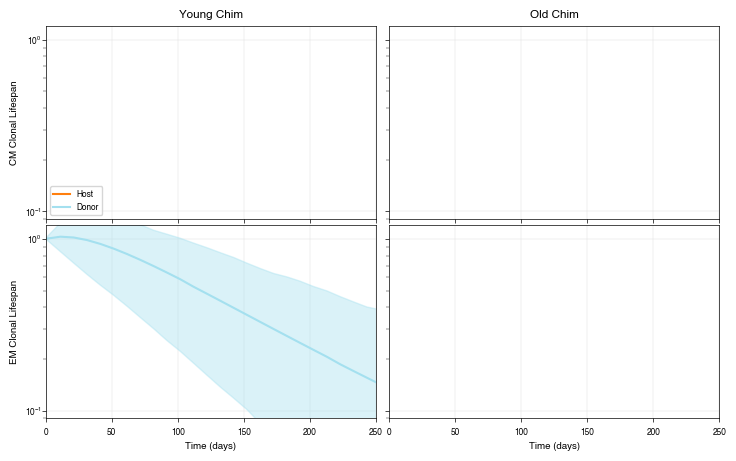

In [3]:

fig, axes = plt.subplots(2, 2, figsize=(7.2,7.2*ratio),sharex=True, sharey=True)

#****************************************************************************************************************

# clonal curves

#****************************************************************************************************************

# d = mpatches.Patch(color="#a4e0ef", label='Donor')
# h = mpatches.Patch(color="#ff7f0e", label='Host')
    
#old cm
mA = np.mean(clonalL[:,:,0], axis=0)
lA, uA = np.percentile(clonalL[:,:,0], axis=0, q=[5, 95])
axes[0,1].plot(np.linspace(1,1000,100), mA, label='Host', color='#ff7f0e')
axes[0,1].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#ff7f0e')
mA = np.mean(clonalL[:,:,2], axis=0)
lA, uA = np.percentile(clonalL[:,:,2], axis=0, q=[5, 95])
axes[0,1].plot(np.linspace(1,1000,100), mA, label='Donor', color='#a4e0ef')
axes[0,1].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#a4e0ef')
axes[0,1].set_title('Old Chim')
axes[0,1].set_xlim([0,250])
axes[0,1].set_ylim([0.09,1.2])
axes[0,1].set_yscale('log')
axes[0,1].tick_params(labelbottom=False, labelleft=False)

#young cm
mA = np.mean(clonalL[:,:,4], axis=0)
lA, uA = np.percentile(clonalL[:,:,4], axis=0, q=[5, 95])
axes[0,0].plot(np.linspace(1,1000,100), mA, label='Host', color='#ff7f0e')
axes[0,0].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#ff7f0e')
mA = np.mean(clonalL[:,:,6], axis=0)
lA, uA = np.percentile(clonalL[:,:,6], axis=0, q=[5, 95])
axes[0,0].plot(np.linspace(1,1000,100), mA, label='Donor', color='#a4e0ef')
axes[0,0].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#a4e0ef')
axes[0,0].set_title('Young Chim')
axes[0,0].set_ylabel('CM Clonal Lifespan')
axes[0,0].tick_params(labelbottom=False)

#old em
mA = np.mean(clonalL[:,:,1], axis=0)
lA, uA = np.percentile(clonalL[:,:,1], axis=0, q=[5, 95])
axes[1,1].plot(np.linspace(1,1000,100), mA, label='Host', color='#ff7f0e')
axes[1,1].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#ff7f0e')
mA = np.mean(clonalL[:,:,3], axis=0)
lA, uA = np.percentile(clonalL[:,:,3], axis=0, q=[5, 95])
axes[1,1].plot(np.linspace(1,1000,100), mA, label='Donor', color='#a4e0ef')
axes[1,1].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#a4e0ef')
axes[1,1].tick_params(labelleft=False)
axes[1,1].set_xlabel('Time (days)')

#young em
mA = np.mean(clonalL[:,:,5], axis=0)
lA, uA = np.percentile(clonalL[:,:,5], axis=0, q=[5, 95])
axes[1,0].plot(np.linspace(1,1000,100), mA, label='Host', color='#ff7f0e')
axes[1,0].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#ff7f0e')
mA = np.mean(clonalL[:,:,7], axis=0)
lA, uA = np.percentile(clonalL[:,:,7], axis=0, q=[5, 95])
axes[1,0].plot(np.linspace(1,1000,100), mA, label='Donor', color='#a4e0ef')
axes[1,0].fill_between(np.linspace(1,1000,100), lA, uA, alpha=0.4, color='#a4e0ef')
axes[1,0].set_xlabel('Time (days)')
axes[1,0].set_ylabel('EM Clonal Lifespan')
axes[0,0].legend(loc='lower left')



#*************************************************************************************************************************

#height_ratios=[1,0.0001,1,0.0001,1], width_ratios = [1,0.001,1])

plt.tight_layout(pad=0.2)

fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/fig4.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)

# fig.savefig('/home/elise/Dropbox/BrdU/Paper/Elise draft 2022/Figures/fig7png.png', dpi='figure', format='png',
#         bbox_inches='tight', pad_inches=0.1)

In [4]:
lamdas = (sam_fl.stan_variable('lamdas') )

print(np.median(clonalL[:,:,7], axis=0))

[1.004310e+00 1.022790e+00 1.012095e+00 9.763740e-01 9.285090e-01
 8.723885e-01 8.073330e-01 7.459250e-01 6.787650e-01 6.172835e-01
 5.617220e-01 5.068805e-01 4.537350e-01 4.105900e-01 3.694500e-01
 3.327655e-01 2.990045e-01 2.678115e-01 2.386060e-01 2.153355e-01
 1.919455e-01 1.706515e-01 1.533845e-01 1.374060e-01 1.235295e-01
 1.107630e-01 9.917705e-02 8.933290e-02 7.993750e-02 7.190265e-02
 6.496630e-02 5.841435e-02 5.230025e-02 4.588760e-02 4.091230e-02
 3.665990e-02 3.253470e-02 2.892695e-02 2.604590e-02 2.341825e-02
 2.101505e-02 1.863755e-02 1.652040e-02 1.483060e-02 1.360515e-02
 1.211020e-02 1.073720e-02 9.521740e-03 8.469505e-03 7.544850e-03
 6.682295e-03 5.923945e-03 5.233820e-03 4.665955e-03 4.174490e-03
 3.636265e-03 3.228075e-03 2.858250e-03 2.538110e-03 2.249970e-03
 1.993600e-03 1.764765e-03 1.562605e-03 1.389340e-03 1.231570e-03
 1.091720e-03 9.635970e-04 8.612230e-04 7.710190e-04 6.913375e-04
 6.130475e-04 5.472065e-04 4.909225e-04 4.330950e-04 3.824195e-04
 3.379315e